Acurácia do SVM: 93.44%
Acurácia do Random Forest: 93.53%


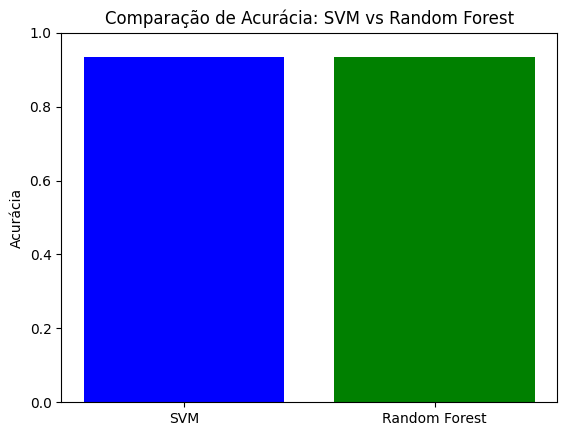

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.io import arff

# Função para carregar dados ARFF
def load_arff_data(file_path):
    file_path = os.path.expanduser(file_path)  # Expande o caminho com '~' para o diretório home
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    # Se houver valores não numéricos, converta-os
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

# Carregar dados de treinamento e teste
train_data = load_arff_data("data/ECG5000/ECG5000_TRAIN.arff")
test_data = load_arff_data("data/ECG5000/ECG5000_TEST.arff")

# Separando as variáveis (atributos) e as classes (labels)
X_train = train_data.drop(columns='target')  # Agora usando 'target' para a coluna de classes
y_train = train_data['target']

X_test = test_data.drop(columns='target')  # Agora usando 'target' para a coluna de classes
y_test = test_data['target']

# Treinamento do classificador SVM
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

# Predição e cálculo de acurácia para o SVM
y_pred_svm = svm_clf.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# Treinamento do classificador Random Forest
rf_clf = RandomForestClassifier(criterion='gini', n_estimators=100)
rf_clf.fit(X_train, y_train)

# Predição e cálculo de acurácia para o Random Forest
y_pred_rf = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Exibindo as acurácias
print(f"Acurácia do SVM: {svm_accuracy * 100:.2f}%")
print(f"Acurácia do Random Forest: {rf_accuracy * 100:.2f}%")

# Plotando as acurácias
models = ['SVM', 'Random Forest']
accuracies = [svm_accuracy, rf_accuracy]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia: SVM vs Random Forest')
plt.ylim(0, 1)
plt.show()


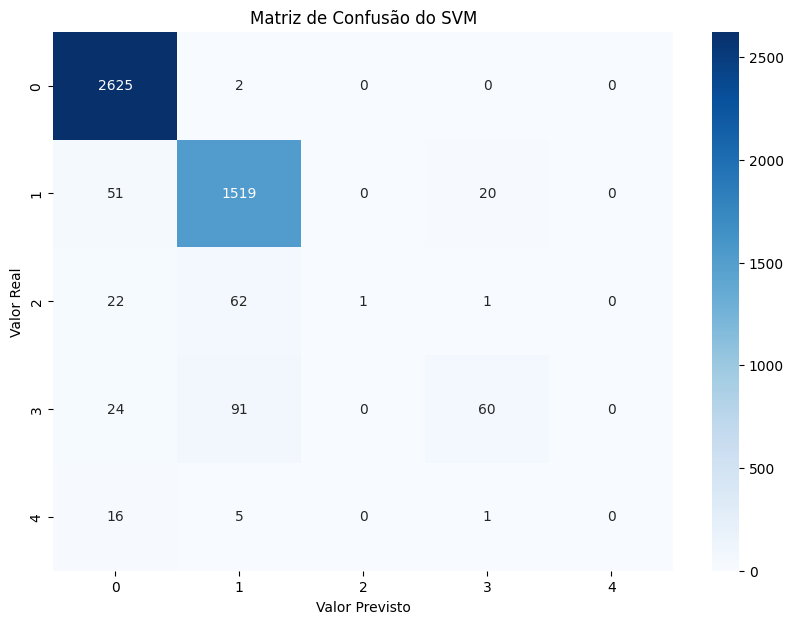

In [4]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusão para o SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão do SVM')
plt.show()

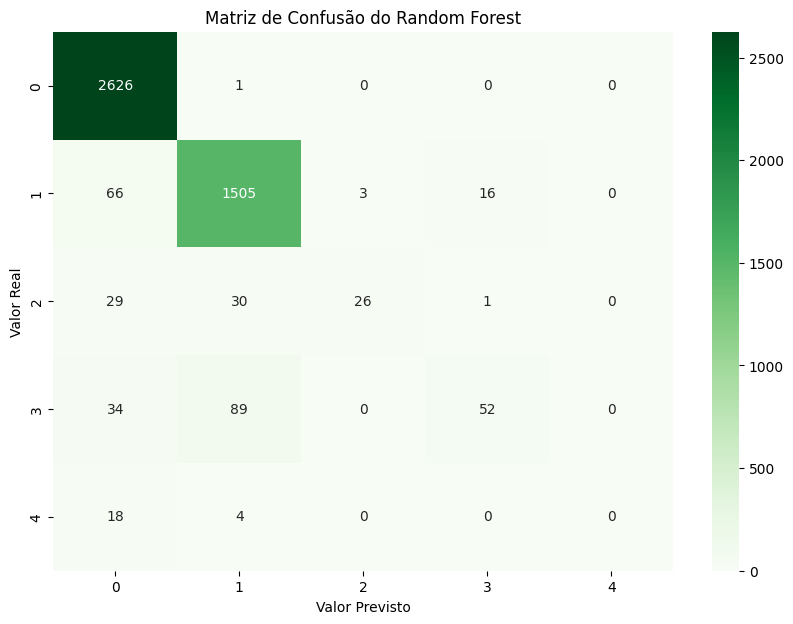

In [6]:
# Matriz de confusão para o Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão do Random Forest')
plt.show()